In [1]:
import latentvelo as ltv
import numpy as np
import scanpy as sc
import scvelo as scv
import matplotlib.pyplot as plt

Global seed set to 0


# Read data synthetic data

In [2]:
adata = sc.read('../synthetic_datasets/bifurcation.h5ad')

# Setup data and train model

In [3]:
ltv.utils.standard_clean_recipe(adata, spliced_key='counts_spliced', unspliced_key='counts_unspliced',
                                 umap=True)

Skip filtering by dispersion since number of variables are less than `n_top_genes`.
computing neighbors
    finished (0:00:10) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


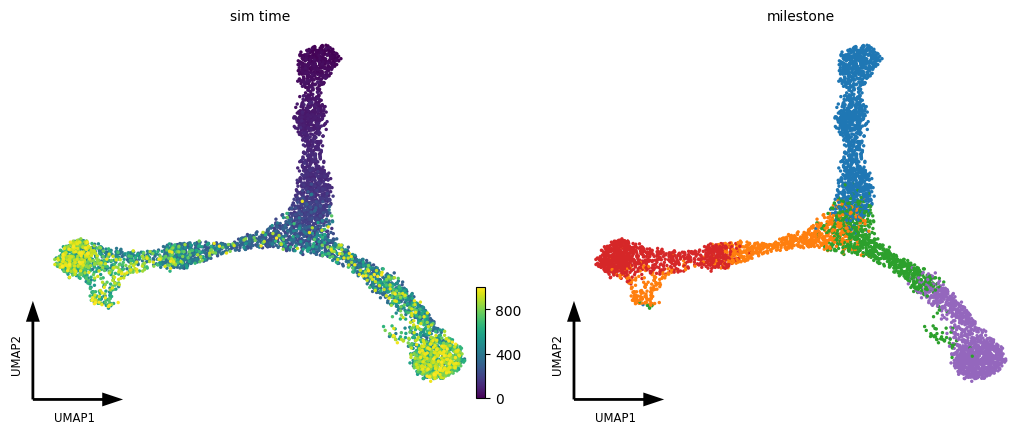

In [4]:
scv.pl.umap(adata, color=['sim_time', 'milestone'], frameon='artist')

In [5]:
model = ltv.models.VAE(observed=65, latent_dim=20, zr_dim=1, h_dim=1)

In [6]:
epochs, val_ae, val_traj = ltv.train(model, adata, batch_size = 100,
                                      epochs=50, name='sythetic_bifurcation_parameters', grad_clip=100)

Warning, folder already exists. This may overwrite a previous fit.
23 velocity genes used
epoch 0, full loss 131.442, val loss 53.844, recon MSE 2.543, traj MSE 0.447, corr reg -2.099
epoch 1, full loss 76.338, val loss 10.383, recon MSE 2.389, traj MSE 0.600, corr reg -2.548
epoch 2, full loss 80.374, val loss -29.435, recon MSE 1.916, traj MSE 0.402, corr reg -2.585
epoch 3, full loss 119.759, val loss -65.765, recon MSE 1.396, traj MSE 0.344, corr reg -3.000
epoch 4, full loss 163.888, val loss -91.563, recon MSE 1.017, traj MSE 0.328, corr reg -2.593
epoch 5, full loss 234.383, val loss -107.294, recon MSE 0.887, traj MSE 0.319, corr reg -2.594
epoch 6, full loss 277.973, val loss -114.656, recon MSE 0.793, traj MSE 0.320, corr reg -2.632
epoch 7, full loss 293.746, val loss -117.138, recon MSE 0.686, traj MSE 0.321, corr reg -2.599
epoch 8, full loss 320.836, val loss -117.896, recon MSE 0.648, traj MSE 0.315, corr reg -2.578
epoch 9, full loss 321.979, val loss -116.667, recon MS

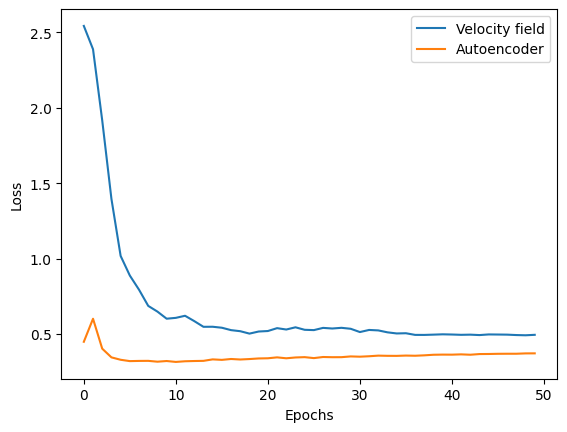

In [7]:
ltv.plot_history(epochs, val_ae, val_traj)
plt.show()

# Compute and plot velocity on umap

In [8]:
latent_adata, adata = ltv.output_results(model, adata, gene_velocity=True)

In [9]:
scv.tl.velocity_graph(latent_adata, vkey='spliced_velocity')

computing velocity graph (using 1/16 cores)


  0%|          | 0/5000 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'spliced_velocity_umap', embedded velocity vectors (adata.obsm)


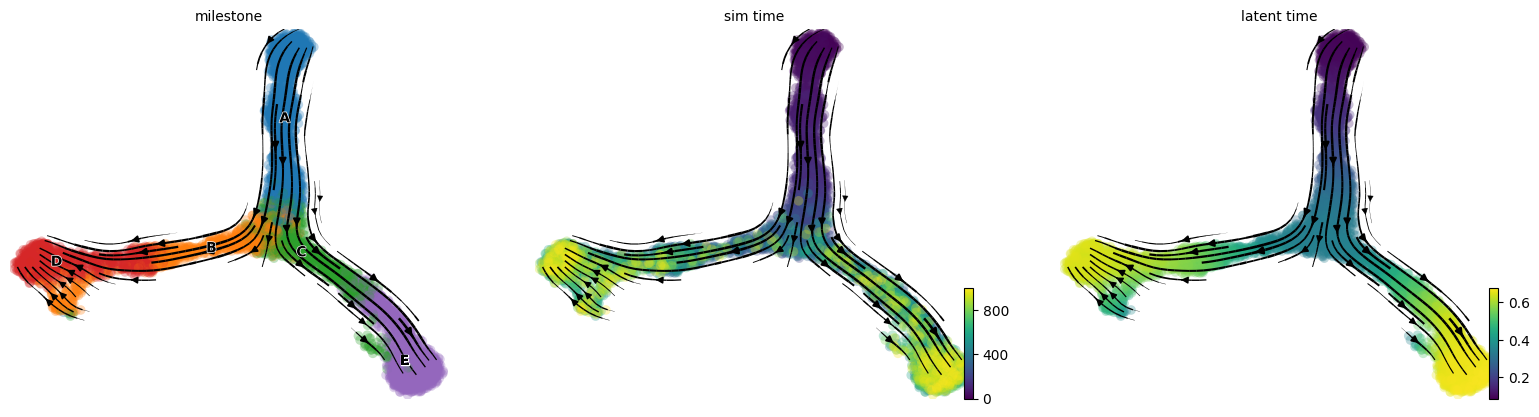

In [10]:
scv.pl.velocity_embedding_stream(latent_adata, vkey='spliced_velocity', 
                                 color=['milestone', 'sim_time', 'latent_time'])

# Compute CBDir transition scores

In [11]:
milestone_edges = [
    ('A', 'B'),
    ('A', 'C'), 
    ('B', 'D'),
    ('C', 'E')]

In [12]:
scv.tl.velocity_embedding(latent_adata, vkey='spliced_velocity', basis='pca')
bifurcation_pca = ltv.ev.cross_boundary_correctness(latent_adata,
                                  'milestone', 'spliced_velocity_pca', milestone_edges, x_emb='X_pca', 
                                                  majority_vote=True, return_raw=True)

computing velocity embedding
    finished (0:00:01) --> added
    'spliced_velocity_pca', embedded velocity vectors (adata.obsm)


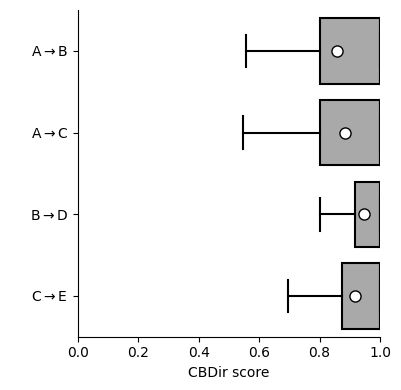

In [13]:
ax=ltv.pl.transition_scores(bifurcation_pca, raw=True)
ax.set(xlim=(0,1))
plt.show()

# Plot z_r scatter

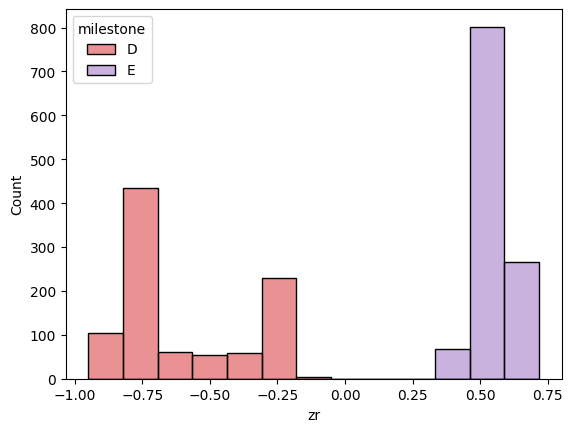

In [14]:
import seaborn as sns
latent_adata.obs['zr'] = latent_adata.obsm['zr'][:,0]
sns.histplot(data=latent_adata[latent_adata.obs.milestone.isin(['D', 'E'])].obs, x='zr',hue='milestone',
               palette=list(latent_adata[latent_adata.obs.milestone.isin(['D', 'E'])].uns['milestone_colors']))
plt.show()

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

clf = LogisticRegression(penalty='none', max_iter=1e4)

data_= latent_adata[latent_adata.obs['milestone'].isin(['D', 'E'])].copy()

X = data_.obs['zr'][:,None]
y = LabelEncoder().fit_transform(data_.obs['milestone'].values)


bif_cvs = cross_val_score(clf, X, y, cv=25)

In [16]:
print('Prediction accuracy (2.5, 50, 97.5) percentiles:', np.percentile(bif_cvs, q=[2.5,50,97.5]))

Prediction accuracy (2.5, 50, 97.5) percentiles: [1. 1. 1.]


# Analyze velocity plots

In [17]:
from scipy.interpolate import griddata
from scipy.stats import gaussian_kde

plt.rcParams.update({'font.size': 18})

def scatter_stream(adata, gene, cluster_key = None, save=False, name_pre = ''):

    s_gene = np.array(adata[:,adata.var.index==gene].layers['spliced'])[:,0] #[:,None]
    u_gene = np.array(adata[:,adata.var.index==gene].layers['unspliced'])[:,0] #[:,None]
    
    adata.obsm['X_'+gene] = np.concatenate((s_gene[:,None], u_gene[:,None]), axis=-1)
    
    vs_gene = np.array(adata[:,adata.var.index==gene].layers['velo_s'])[:,0]
    vu_gene = np.array(adata[:,adata.var.index==gene].layers['velo_u'])[:,0]
    
    
    x = np.linspace(s_gene.min()*1.1, s_gene.max()*0.9, 250)
    y = np.linspace(u_gene.min()*1.1, u_gene.max()*0.9, 250)

    S, U = np.meshgrid(x, y)# s_gene, u_gene)
    
    VS = griddata((s_gene, u_gene), vs_gene, (S, U), method='linear')
    VU = griddata((s_gene, u_gene), vu_gene, (S, U), method='linear')
    
    kernel = gaussian_kde(adata.obsm['X_'+gene][(s_gene > 0) & (u_gene > 0)].T)
    
    positions = np.vstack([S.ravel(), U.ravel()])
    density = np.reshape(kernel(positions).T, S.shape)

    VS[density< 0.5] = np.nan
    VU[density< 0.5] = np.nan
    
    fig,ax=plt.subplots()
    plt.streamplot(S, U, VS, VU, color='k', linewidth=1.5, arrowsize=1.5)
    
    sc.pl.scatter(adata, basis=gene, color=cluster_key, ax=ax, title = gene, 
                  frameon=True, legend_loc='right', show=False, size=100, legend_fontsize=18, color_map='coolwarm')
    ax.set_xlabel('spliced')
    ax.set_ylabel('unspliced')
    if save:
        plt.savefig('figures/' + name_pre + str(gene) + '.pdf')
    else:
        return fig

In [18]:
adata.var.iloc[np.argsort(-1*adata.var['R2'])]['R2'][:10]

HK7         0.922003
Target3     0.880839
HK14        0.843053
A6_TF1      0.808026
Target10    0.777979
B4_TF1      0.737211
B5_TF1      0.733842
B1_TF1      0.717989
Target9     0.713913
Target13    0.683971
Name: R2, dtype: float64

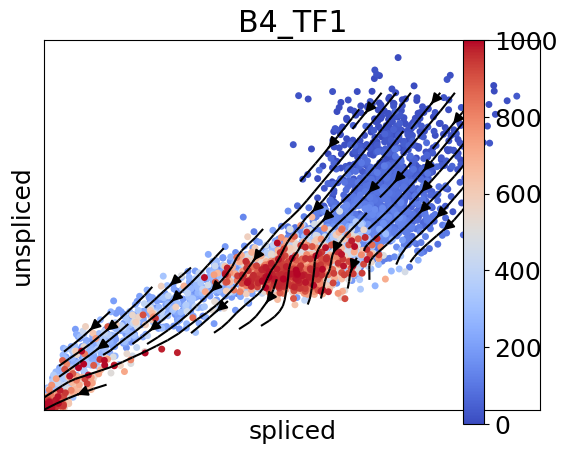

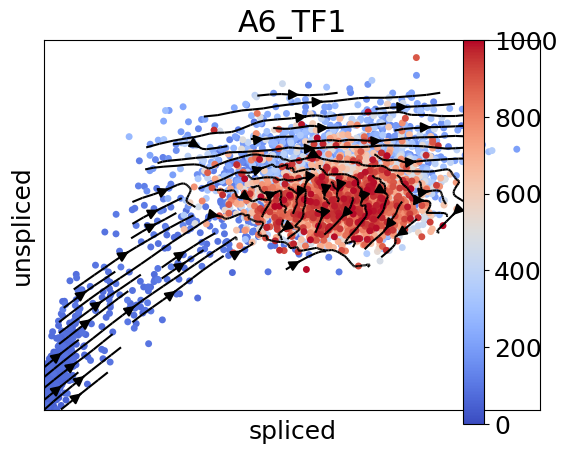

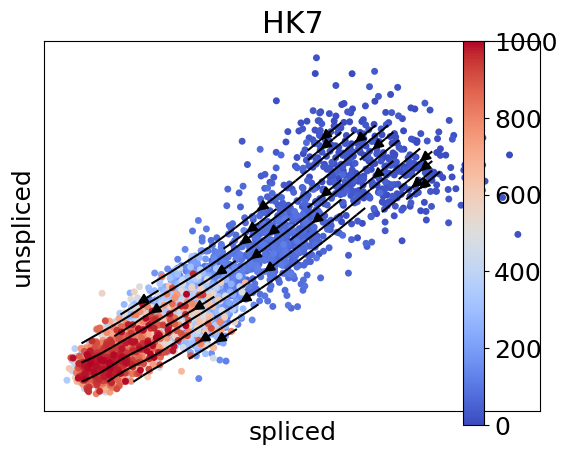

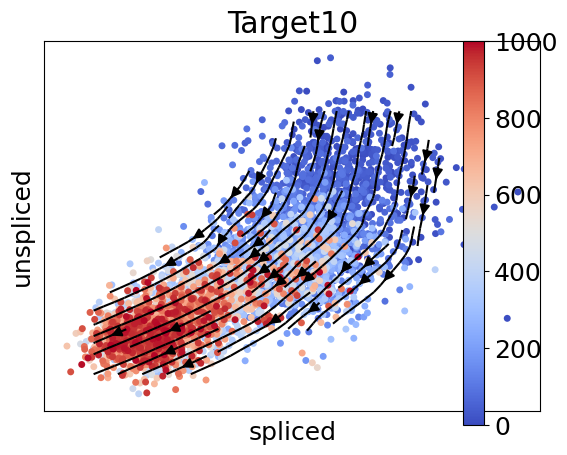

In [19]:

scatter_stream(adata, 'B4_TF1', cluster_key='sim_time')
plt.show()

scatter_stream(adata, 'A6_TF1', cluster_key='sim_time')
plt.show()

scatter_stream(adata, 'HK7', cluster_key='sim_time')
plt.show()

scatter_stream(adata, 'Target10', cluster_key='sim_time')
plt.show()